<a href="https://colab.research.google.com/github/adhang/learn-data-science/blob/main/Spaceship_Titanic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Titanic

Author: Adhang Muntaha Muhammad

[![LinkedIn](https://img.shields.io/badge/linkedin-0077B5?style=for-the-badge&logo=linkedin&logoColor=white&link=https://www.linkedin.com/in/adhangmuntaha/)](https://www.linkedin.com/in/adhangmuntaha/)
[![GitHub](https://img.shields.io/badge/github-121011?style=for-the-badge&logo=github&logoColor=white&link=https://github.com/adhang)](https://github.com/adhang)
[![Kaggle](https://img.shields.io/badge/kaggle-20BEFF?style=for-the-badge&logo=kaggle&logoColor=white&link=https://www.kaggle.com/adhang)](https://www.kaggle.com/adhang)
[![Tableau](https://img.shields.io/badge/tableau-E97627?style=for-the-badge&logo=tableau&logoColor=white&link=https://public.tableau.com/app/profile/adhang)](https://public.tableau.com/app/profile/adhang)
___

**Contents**
1. Introduction
2. Importing Libraries
3. Dataset Overview
4. Feature Extraction
5. Impute by Knowledge
6. Impute Using DataWig

# 1. Introduction

**Features**
- `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Importing Libraries

In [ ]:
!pip install --upgrade matplotlib
!pip install --upgrade seaborn

!pip install xgboost
!pip install lightgbm
!pip install catboost

!pip install datawig
!pip install inflection
!pip install dython

!pip install shap
!pip install optuna

In [118]:
import pandas as pd
import numpy as np
import optuna

# viz
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':1.5})

# save model
import joblib

# snake_case
import inflection

# train test split
from sklearn.model_selection import train_test_split

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

# model
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# evaluation
import sklearn.metrics
from sklearn.metrics import classification_report

# pipeline
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config

# Reading Dataset

In [8]:
path = 'https://raw.githubusercontent.com/adhang/datasets/main/spaceship-titanic-train-clean.csv'

data = pd.read_csv(path)
data.head()

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,passenger_group,passenger_num,cabin_deck,cabin_num,cabin_side,total_bill,cabin_update
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,0.0,B/0/P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,736.0,F/0/S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S,10383.0,A/0/S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S,5176.0,A/0/S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S,1091.0,F/1/S


# Data Preprocessing

## Bool Data Type

In [10]:
bool_col = ['cryo_sleep', 'vip', 'transported']
data.loc[:, bool_col] = data.loc[:, bool_col].replace({True:'TRUE', False:'FALSE'})

data.head()

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,passenger_group,passenger_num,cabin_deck,cabin_num,cabin_side,total_bill,cabin_update
0,Europa,FALSE,TRAPPIST-1e,39.0,FALSE,0.0,0.0,0.0,0.0,0.0,FALSE,1,1,B,0,P,0.0,B/0/P
1,Earth,FALSE,TRAPPIST-1e,24.0,FALSE,109.0,9.0,25.0,549.0,44.0,TRUE,2,1,F,0,S,736.0,F/0/S
2,Europa,FALSE,TRAPPIST-1e,58.0,TRUE,43.0,3576.0,0.0,6715.0,49.0,FALSE,3,1,A,0,S,10383.0,A/0/S
3,Europa,FALSE,TRAPPIST-1e,33.0,FALSE,0.0,1283.0,371.0,3329.0,193.0,FALSE,3,2,A,0,S,5176.0,A/0/S
4,Earth,FALSE,TRAPPIST-1e,16.0,FALSE,303.0,70.0,151.0,565.0,2.0,TRUE,4,1,F,1,S,1091.0,F/1/S


## Total Bill

In [11]:
data['total_bill'] = data['room_service'] + data['food_court'] + data['shopping_mall'] + data['spa'] + data['vr_deck']

data.head()

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,passenger_group,passenger_num,cabin_deck,cabin_num,cabin_side,total_bill,cabin_update
0,Europa,FALSE,TRAPPIST-1e,39.0,FALSE,0.0,0.0,0.0,0.0,0.0,FALSE,1,1,B,0,P,0.0,B/0/P
1,Earth,FALSE,TRAPPIST-1e,24.0,FALSE,109.0,9.0,25.0,549.0,44.0,TRUE,2,1,F,0,S,736.0,F/0/S
2,Europa,FALSE,TRAPPIST-1e,58.0,TRUE,43.0,3576.0,0.0,6715.0,49.0,FALSE,3,1,A,0,S,10383.0,A/0/S
3,Europa,FALSE,TRAPPIST-1e,33.0,FALSE,0.0,1283.0,371.0,3329.0,193.0,FALSE,3,2,A,0,S,5176.0,A/0/S
4,Earth,FALSE,TRAPPIST-1e,16.0,FALSE,303.0,70.0,151.0,565.0,2.0,TRUE,4,1,F,1,S,1091.0,F/1/S


## Train - Test Split

In [23]:
data_X = data.drop(['transported', 'cabin_update'], axis=1)
data_y = data['transported']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3,
                                                    random_state=1, stratify=data_y)

In [24]:
print('X shape\t\t:', data_X.shape)
print('y shape\t\t:', data_y.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape\t:', X_test.shape)
print('y_test shape\t:', y_test.shape)

X shape		: (8693, 16)
y shape		: (8693,)

X_train shape	: (6085, 16)
y_train shape	: (6085,)

X_test shape	: (2608, 16)
y_test shape	: (2608,)


In [37]:
column_categorical = data_X.select_dtypes(exclude=np.number).columns.tolist()
column_categorical

['home_planet', 'cryo_sleep', 'destination', 'vip', 'cabin_deck', 'cabin_side']

In [38]:
column_numerical = data_X.select_dtypes(include=np.number).columns.tolist()
column_numerical

['age',
 'room_service',
 'food_court',
 'shopping_mall',
 'spa',
 'vr_deck',
 'passenger_group',
 'passenger_num',
 'cabin_num',
 'total_bill']

## Label Encoding

I use it for the target variable (label).

In [25]:
le = LabelEncoder()

le.fit(y_train)

y_train_encode = le.transform(y_train)
y_test_encode = le.transform(y_test)

In [26]:
le.classes_

array(['FALSE', 'TRUE'], dtype=object)

## One Hot Encoding

In [28]:
# drop 1 category if the feature only has 2 categories
ohe = OneHotEncoder(sparse=False, drop='if_binary')

ohe.fit(X_train[column_categorical])

X_train_ohe = ohe.transform(X_train[column_categorical])
X_test_ohe = ohe.transform(X_test[column_categorical])

## Encoded Dataframe

I will combine the encoded features and the numerical features. Make sure that the index is the same.

In [29]:
column_ohe = ohe.get_feature_names_out()
column_ohe

array(['home_planet_Earth', 'home_planet_Europa', 'home_planet_Mars',
       'cryo_sleep_TRUE', 'destination_55 Cancri e',
       'destination_PSO J318.5-22', 'destination_TRAPPIST-1e', 'vip_TRUE',
       'cabin_deck_A', 'cabin_deck_B', 'cabin_deck_C', 'cabin_deck_D',
       'cabin_deck_E', 'cabin_deck_F', 'cabin_deck_G', 'cabin_deck_T',
       'cabin_side_S'], dtype=object)

In [33]:
for i, col in enumerate(column_ohe):
  column_ohe[i] = inflection.underscore(column_ohe[i])

column_ohe

array(['home_planet_earth', 'home_planet_europa', 'home_planet_mars',
       'cryo_sleep_true', 'destination_55_cancri_e',
       'destination_pso_j318.5_22', 'destination_trappist_1e', 'vip_true',
       'cabin_deck_a', 'cabin_deck_b', 'cabin_deck_c', 'cabin_deck_d',
       'cabin_deck_e', 'cabin_deck_f', 'cabin_deck_g', 'cabin_deck_t',
       'cabin_side_s'], dtype=object)

### Train Set

In [34]:
# create dataframe from one-hot encoded features
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=column_ohe, index=X_train.index)

# combine the numerical and encoded features
X_train_encode = pd.concat([X_train.drop(columns=column_categorical), X_train_ohe_df], axis=1)
X_train_encode.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,passenger_group,passenger_num,cabin_num,total_bill,...,vip_true,cabin_deck_a,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_side_s
5992,42.0,0.0,0.0,0.0,0.0,0.0,6343,1,423,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8308,38.0,0.0,0.0,0.0,0.0,0.0,8867,2,286,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4863,9.0,0.0,0.0,0.0,0.0,0.0,5188,2,838,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
478,50.0,0.0,0.0,0.0,0.0,0.0,515,1,20,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2670,17.0,5.0,756.0,0.0,0.0,0.0,2861,1,547,761.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Test Set

In [35]:
# create dataframe from one-hot encoded features
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=column_ohe, index=X_test.index)

# combine the numerical and encoded features
X_test_encode = pd.concat([X_test.drop(columns=column_categorical), X_test_ohe_df], axis=1)
X_test_encode.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,passenger_group,passenger_num,cabin_num,total_bill,...,vip_true,cabin_deck_a,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_side_s
1585,34.0,1.0,89.0,0.0,793.0,0.0,1681,1,261,883.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7347,6.0,0.0,0.0,0.0,0.0,0.0,7861,1,1265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2058,43.0,2019.0,0.0,560.0,0.0,0.0,2203,1,76,2579.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8483,22.0,0.0,0.0,0.0,0.0,0.0,9069,1,297,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,19.0,0.0,0.0,0.0,0.0,0.0,219,1,36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Combine

In [36]:
# combine the X-train and X-test
data_encode = pd.concat([X_train_encode, X_test_encode], axis=0)

# combine with the y-train
data_encode = data_encode.join(pd.Series(y_train_encode, name='transported', index=X_train_encode.index), lsuffix='_1', rsuffix='_2')

# combine with the y-test
data_encode = data_encode.join(pd.Series(y_test_encode, name='transported', index=X_test_encode.index), lsuffix='_1', rsuffix='_2')

# merging the y-train and y-test column
data_encode['transported_1'].fillna(data_encode['transported_2'], inplace=True)
data_encode.drop(columns='transported_2', inplace=True)
data_encode.rename(columns={'transported_1':'transported'}, inplace=True)

data_encode.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,passenger_group,passenger_num,cabin_num,total_bill,...,cabin_deck_a,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_side_s,transported
5992,42.0,0.0,0.0,0.0,0.0,0.0,6343,1,423,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
8308,38.0,0.0,0.0,0.0,0.0,0.0,8867,2,286,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4863,9.0,0.0,0.0,0.0,0.0,0.0,5188,2,838,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
478,50.0,0.0,0.0,0.0,0.0,0.0,515,1,20,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2670,17.0,5.0,756.0,0.0,0.0,0.0,2861,1,547,761.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


## Feature Scaling

Since this dataset is very skewed, I'm gonna use PowerTransform.

In [75]:
column_numerical

['age',
 'room_service',
 'food_court',
 'shopping_mall',
 'spa',
 'vr_deck',
 'passenger_group',
 'passenger_num',
 'cabin_num',
 'total_bill']

In [58]:
X_train_scale = X_train_encode.copy()
X_test_scale = X_test_encode.copy()

for i in column_numerical:
  scaler = PowerTransformer()
  scaler.fit(X_train_scale[[i]])

  X_train_scale[[i]] = scaler.transform(X_train_scale[[i]])
  X_test_scale[[i]] = scaler.transform(X_test_scale[[i]])

## Scaled Dataframe
This dataframe has been encoded and scaled

In [84]:
# combine the X-train and X-test
data_scale = pd.concat([X_train_scale, X_test_scale], axis=0)

# combine with the y-train
data_scale = data_scale.join(pd.Series(y_train_encode, name='transported', index=X_train_scale.index), lsuffix='_1', rsuffix='_2')

# combine with the y-test
data_scale = data_scale.join(pd.Series(y_test_encode, name='transported', index=X_test_scale.index), lsuffix='_1', rsuffix='_2')

# merging the y-train and y-test column
data_scale['transported_1'].fillna(data_scale['transported_2'], inplace=True)
data_scale.drop(columns='transported_2', inplace=True)
data_scale.rename(columns={'transported_1':'transported'}, inplace=True)

data_scale.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,passenger_group,passenger_num,cabin_num,total_bill,...,cabin_deck_a,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_side_s,transported
5992,0.923476,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,0.674505,-0.630892,-0.014110,-1.145010,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
8308,0.673448,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,1.441839,1.431748,-0.354169,-1.145010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4863,-1.432089,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,0.294006,1.431748,0.691943,-1.145010,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
478,1.406845,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,-1.712942,-0.630892,-1.808242,-1.145010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2670,-0.774876,0.645745,1.557943,-0.690274,-0.74308,-0.711803,-0.562177,-0.630892,0.233523,0.565648,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [85]:
data_scale_train = pd.concat([X_train_scale, pd.Series(y_train_encode, name='transported', index=X_train_scale.index)], axis=1)
data_scale_train.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,passenger_group,passenger_num,cabin_num,total_bill,...,cabin_deck_a,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_side_s,transported
5992,0.923476,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,0.674505,-0.630892,-0.014110,-1.145010,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
8308,0.673448,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,1.441839,1.431748,-0.354169,-1.145010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4863,-1.432089,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,0.294006,1.431748,0.691943,-1.145010,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
478,1.406845,-0.691584,-0.714797,-0.690274,-0.74308,-0.711803,-1.712942,-0.630892,-1.808242,-1.145010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2670,-0.774876,0.645745,1.557943,-0.690274,-0.74308,-0.711803,-0.562177,-0.630892,0.233523,0.565648,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


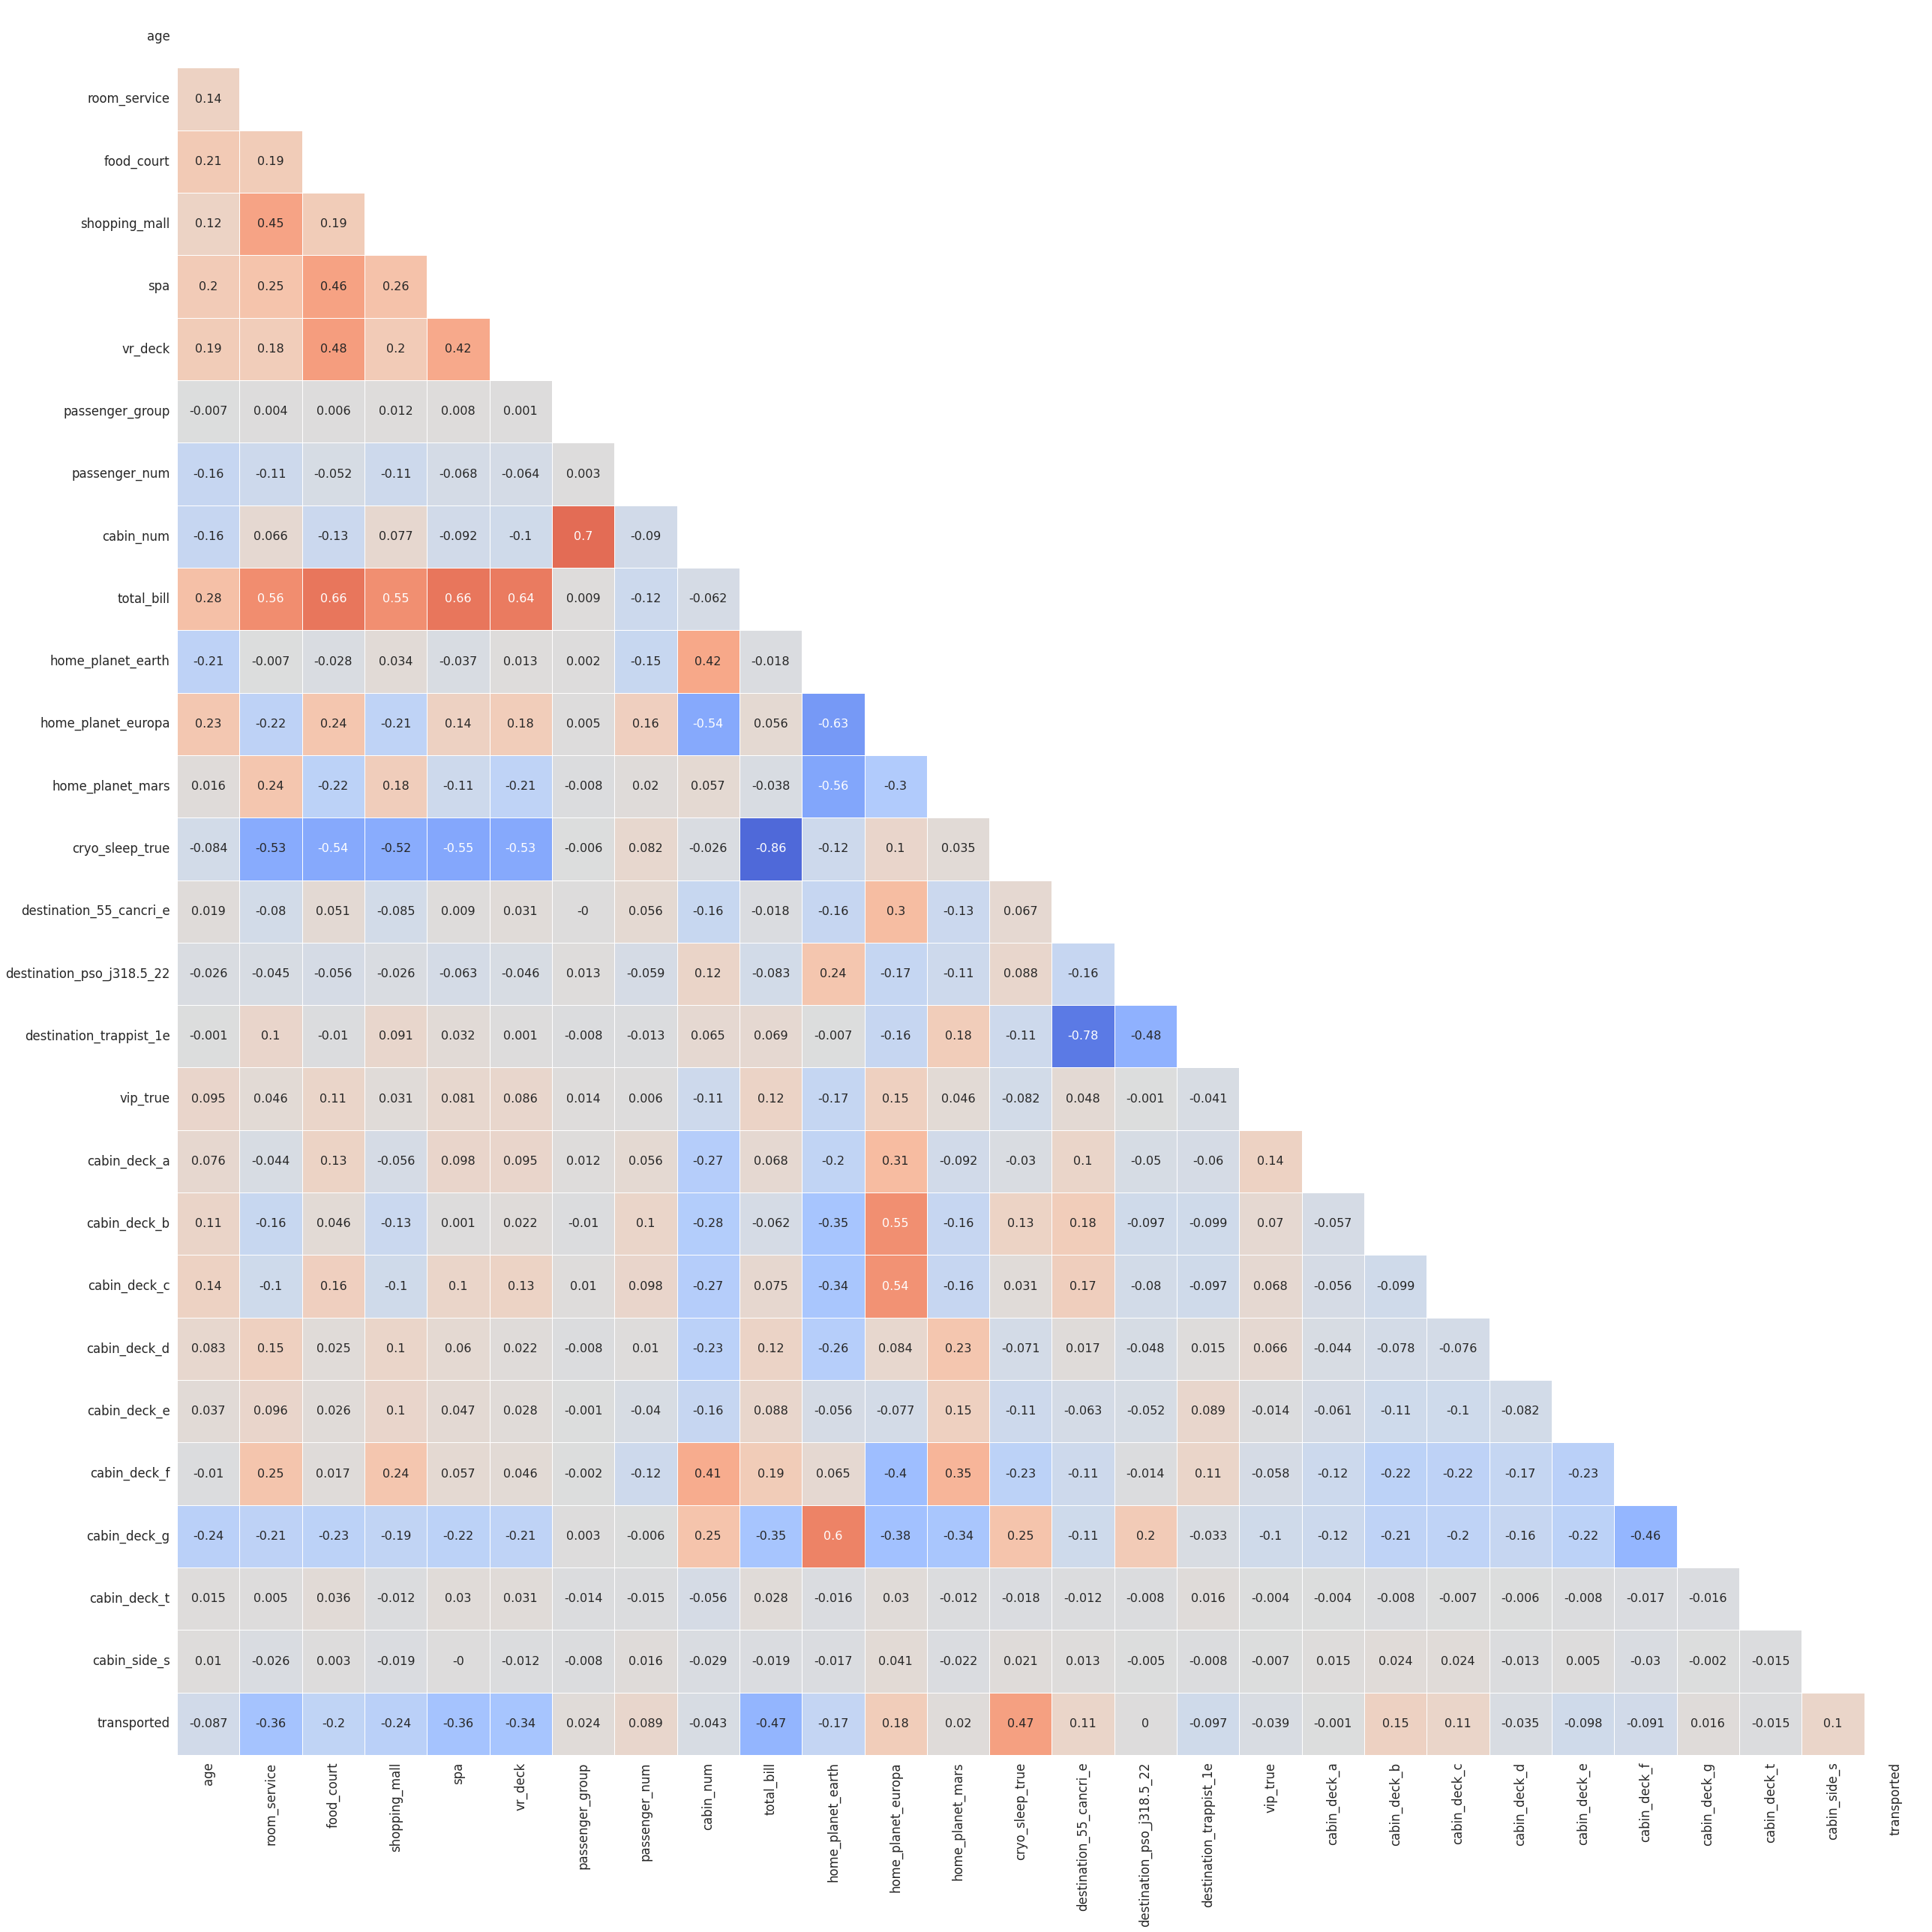

In [89]:
corr_matrix = data_scale.corr().round(3)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cbar=False,
            cmap='coolwarm', linewidth=1, mask=mask,
            square=True, annot=True, annot_kws={'fontsize':16}, ax=ax)

plt.show()

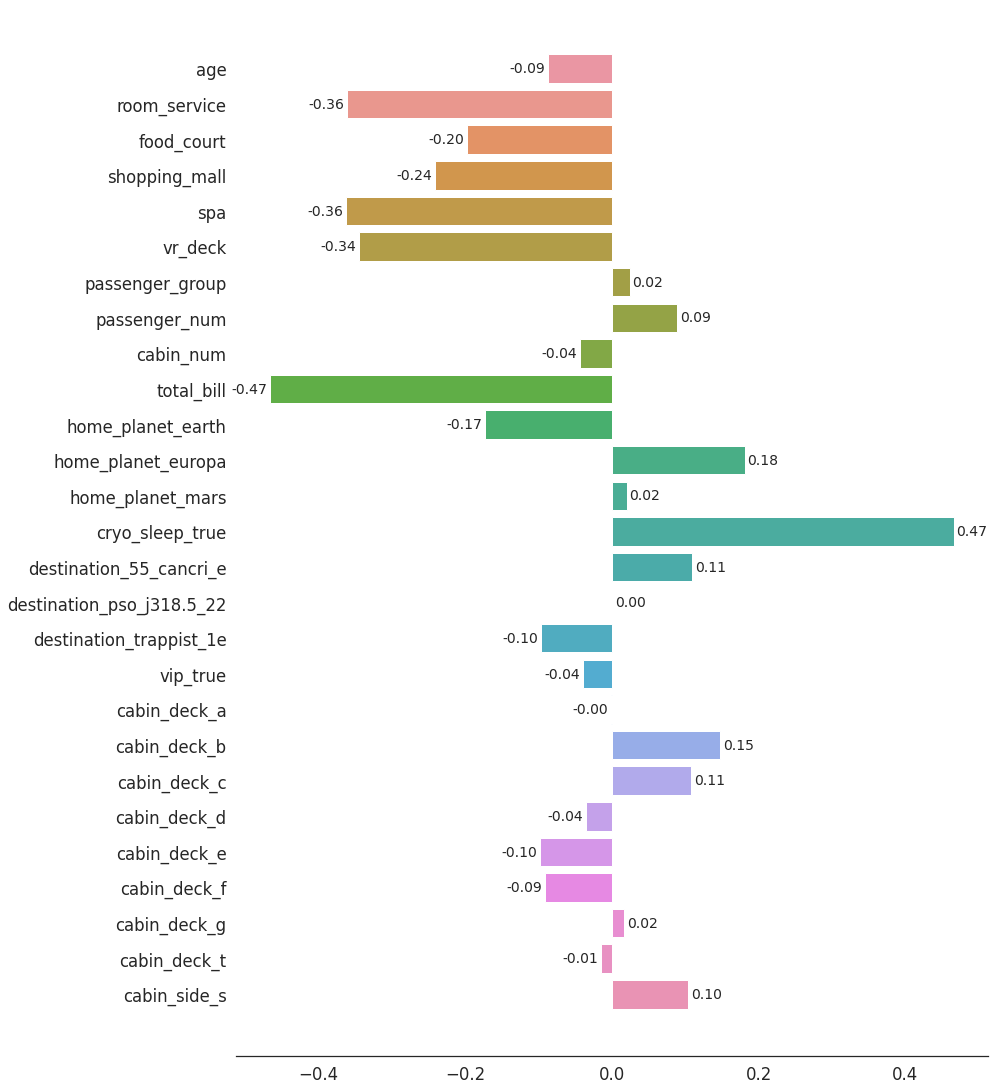

In [90]:
corr_matrix = data_scale.corr().round(3)
corr_target = corr_matrix['transported'].drop('transported')

fig, ax = plt.subplots(figsize=(12,18))

sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax)
ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

ax.axis('tight')
sns.despine(left=True)
plt.show()

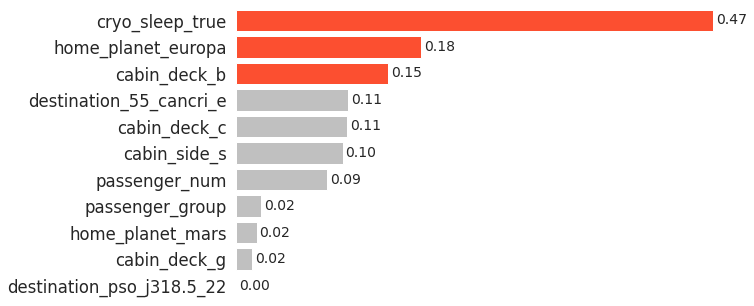

In [91]:
corr_matrix = data_scale.corr().round(3)
corr_target = corr_matrix['transported'].drop('transported').sort_values(ascending=False)

corr_positive = corr_target[corr_target >= 0]

threshold_top = 3
palette = []
for i in range(0, len(corr_positive)):
  if i < threshold_top:
    palette.append('#FC4F30') # red
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(x=corr_positive.values, y=corr_positive.index, ax=ax, palette=palette, saturation=1)

ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

ax.set_xticklabels([])
sns.despine(left=True, bottom=True)

plt.show()

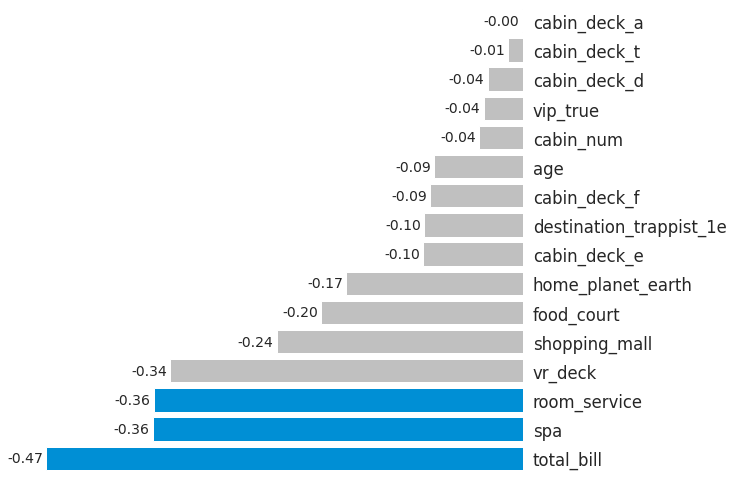

In [92]:
corr_negative = corr_target[corr_target < 0]

threshold_top = 3
threshold_bot = corr_negative.size - threshold_top - 1
palette = []
for i in range(0, len(corr_negative)):
  if i > threshold_bot:
    palette.append('#008FD5') # blue
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(x=corr_negative.values, y=corr_negative.index, ax=ax, palette=palette, saturation=1)

ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xticklabels([])

sns.despine(left=True, bottom=True)
plt.tick_params(right=False)

plt.show()

# Model Development

In [93]:
X_train_model = X_train_scale.copy()
y_train_model = y_train_encode.copy()

X_test_model = X_test_scale.copy()
y_test_model = y_test_encode.copy()

## XGBoost

### Tuning with Optuna

In [94]:
def objective(trial):
  dtrain = xgb.DMatrix(X_train_model, label=y_train_model)
  dvalid = xgb.DMatrix(X_test_model, label=y_test_model)

  param = {
    "verbosity": 0,
    "objective": "binary:logistic",
    # use exact for small dataset.
    "tree_method": "exact",
    # defines booster, gblinear for linear functions.
    "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    # L2 regularization weight.
    "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    # L1 regularization weight.
    "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    # sampling ratio for training data.
    "subsample": trial.suggest_float("subsample", 0.2, 1.0),
    # sampling according to each tree.
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree", "dart"]:
    # maximum depth of the tree, signifies complexity of the tree.
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    # minimum child weight, larger the term more conservative the tree.
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    # defines how selective algorithm is.
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
    param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  bst = xgb.train(param, dtrain)
  preds = bst.predict(dvalid)
  pred_labels = np.rint(preds)
  accuracy = sklearn.metrics.accuracy_score(y_test_model, pred_labels)
  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

### Training Model

In [100]:
model = XGBClassifier(random_state=1)
model.set_params(**trial.params)

XGBClassifier(alpha=0.2678643758479034, colsample_bytree=0.8214644262107696,
              eta=0.3128226844866787, gamma=0.3447928436626635,
              grow_policy='lossguide', lambda=3.878804198090908e-07,
              max_depth=9, min_child_weight=6, random_state=1,
              subsample=0.926134551775181)

In [103]:
model.fit(X_train_model, y_train_model)

y_pred = model.predict(X_test_model)

print(classification_report(y_test_model, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.815     0.812     0.814      1295
           1      0.815     0.818     0.817      1313

    accuracy                          0.815      2608
   macro avg      0.815     0.815     0.815      2608
weighted avg      0.815     0.815     0.815      2608



### Pipeline

In [111]:
data_X = data.drop(['transported', 'cabin_update'], axis=1)
data_y = data['transported']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3,
                                                    random_state=1, stratify=data_y)

In [112]:
le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [116]:
transformer_numerical = Pipeline(steps=[('scaler', PowerTransformer())])

transformer_categorical = Pipeline(steps=[('encoder', OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('numerical', transformer_numerical, column_numerical),
                                               ('categorical', transformer_categorical, column_categorical)], remainder='passthrough')

model = XGBClassifier(random_state=1)
model.set_params(**trial.params)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('estimator', model)])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.815     0.812     0.814      1295
           1      0.815     0.818     0.817      1313

    accuracy                          0.815      2608
   macro avg      0.815     0.815     0.815      2608
weighted avg      0.815     0.815     0.815      2608



### Save Model

In [117]:
path = '/content/drive/MyDrive/My Projects/2022/Titanic Spaceship/model/trained_model.pkl'

joblib.dump(pipeline, path)

['/content/drive/MyDrive/My Projects/2022/Titanic Spaceship/model/trained_model.pkl']

## LightGBM

### Tuning with Optuna

In [124]:
def objective(trial):
  dtrain = lgb.Dataset(X_train_model, label=y_train_model)

  param = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  gbm = lgb.train(param, dtrain)
  preds = gbm.predict(X_test_model)
  pred_labels = np.rint(preds)
  accuracy = sklearn.metrics.accuracy_score(y_test_model, pred_labels)
  return accuracy

In [125]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2022-05-04 04:07:37,787] A new study created in memory with name: no-name-2b3956dc-2ef2-4281-b2f4-d32bf28c2c00
[I 2022-05-04 04:07:38,196] Trial 0 finished with value: 0.8132668711656442 and parameters: {'lambda_l1': 7.270865476862867, 'lambda_l2': 0.0003751422478529937, 'num_leaves': 69, 'feature_fraction': 0.6618020561007241, 'bagging_fraction': 0.7110040843670351, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 0.8132668711656442.
[I 2022-05-04 04:07:38,770] Trial 1 finished with value: 0.8128834355828221 and parameters: {'lambda_l1': 4.290262131067773e-06, 'lambda_l2': 0.8113181187355843, 'num_leaves': 46, 'feature_fraction': 0.8550793130411791, 'bagging_fraction': 0.6894080519686177, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 0 with value: 0.8132668711656442.
[I 2022-05-04 04:07:39,163] Trial 2 finished with value: 0.816717791411043 and parameters: {'lambda_l1': 0.1354773161555926, 'lambda_l2': 9.925149372917144, 'num_leaves': 207, 'feat

Number of finished trials:  100
Best trial:
  Value: 0.8232361963190185
  Params: 
    lambda_l1: 2.0017209630915411e-07
    lambda_l2: 0.0022970487503227725
    num_leaves: 174
    feature_fraction: 0.46681502437480765
    bagging_fraction: 0.8095234131531482
    bagging_freq: 3
    min_child_samples: 82


### Training Model

In [126]:
model = LGBMClassifier(random_state=1)
model.set_params(**trial.params)

LGBMClassifier(bagging_fraction=0.8095234131531482, bagging_freq=3,
               feature_fraction=0.46681502437480765,
               lambda_l1=2.0017209630915411e-07,
               lambda_l2=0.0022970487503227725, min_child_samples=82,
               num_leaves=174, random_state=1)

In [127]:
model.fit(X_train_model, y_train_model)

y_pred = model.predict(X_test_model)

print(classification_report(y_test_model, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.809     0.810     0.809      1295
           1      0.812     0.811     0.812      1313

    accuracy                          0.811      2608
   macro avg      0.811     0.811     0.811      2608
weighted avg      0.811     0.811     0.811      2608



### Pipeline

In [128]:
data_X = data.drop(['transported', 'cabin_update'], axis=1)
data_y = data['transported']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3,
                                                    random_state=1, stratify=data_y)

In [129]:
le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [130]:
transformer_numerical = Pipeline(steps=[('scaler', PowerTransformer())])

transformer_categorical = Pipeline(steps=[('encoder', OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('numerical', transformer_numerical, column_numerical),
                                               ('categorical', transformer_categorical, column_categorical)], remainder='passthrough')

model = LGBMClassifier(random_state=1)
model.set_params(**trial.params)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('estimator', model)])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.809     0.810     0.809      1295
           1      0.812     0.811     0.812      1313

    accuracy                          0.811      2608
   macro avg      0.811     0.811     0.811      2608
weighted avg      0.811     0.811     0.811      2608



### Save Model

In [131]:
path = '/content/drive/MyDrive/My Projects/2022/Titanic Spaceship/model/trained_model_lgbm.pkl'

joblib.dump(pipeline, path)

['/content/drive/MyDrive/My Projects/2022/Titanic Spaceship/model/trained_model_lgbm.pkl']

## Feature Selection